<a href="https://colab.research.google.com/github/OnurKerimoglu/bayesian_mmm/blob/main/examples/bayesian_mmm_example_enhanced_newdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Problem Statement and the proposed Bayesian MMM solution

Consider a company, which runs an online shop, and advertises on seven different paid channels (TV, radio, billboards, Google Ads, etc). Based on weekly data on weekly advertisement costs and revenue available for 2 years, the company would like to understand how effective different channels are. One has to take into account that marketing actions have usually not an immediate effect, ads and campaigns in one week may influence sales in the coming weeks. So different channels can be expected to target different audiences at different times and for different durations, and hence will have lagged effects on revenue.

For this problem, I used a Bayesian Media Mix Modelling approach. MMM can be perfomed with a simpler linear regression approach, however with a bayesian approach, we can find more robust solutions, and estimate confidence intervals. For this work, I took inspiration and used code from the following sources:

- [Blogpost #1](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a) by Robert Kübler
- [Blogpost #2](https://towardsdatascience.com/modeling-marketing-mix-using-pymc3-ba18dd9e6e68) by Slava Kisilevich
- [Git repo #1](https://github.com/slavakx/bayesian_mmm) by Slava Kisilevich
- [Git repo #2](https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb) by Ilya Katsov
- [Jin et al. 2017](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)

# Install / Import Packages

In [20]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import arviz as az
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
import pymc3 as pm3
import seaborn as sns
import theano
import theano.tensor as tt

from sklearn.preprocessing import MinMaxScaler #, #StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


# Prepare Data

In [22]:
data_wdates = pd.read_csv(
  'https://raw.githubusercontent.com/OnurKerimoglu/bayesian_mmm/master/data/MMM_test_data.csv',
  parse_dates=['start_of_week']
)

## Detect Trend and Seasonality

Let's first detect the trend ans seasonility in the data, which we will use as control variables in our model. 

In [23]:
prophet_data = data_wdates.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)

prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxolsonc/ta6vot5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxolsonc/8ol3bw1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27902', 'data', 'file=/tmp/tmpaxolsonc/ta6vot5q.json', 'init=/tmp/tmpaxolsonc/8ol3bw1x.json', 'output', 'file=/tmp/tmpaxolsonc/prophet_modelsltfb633/prophet_model-20230204193112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


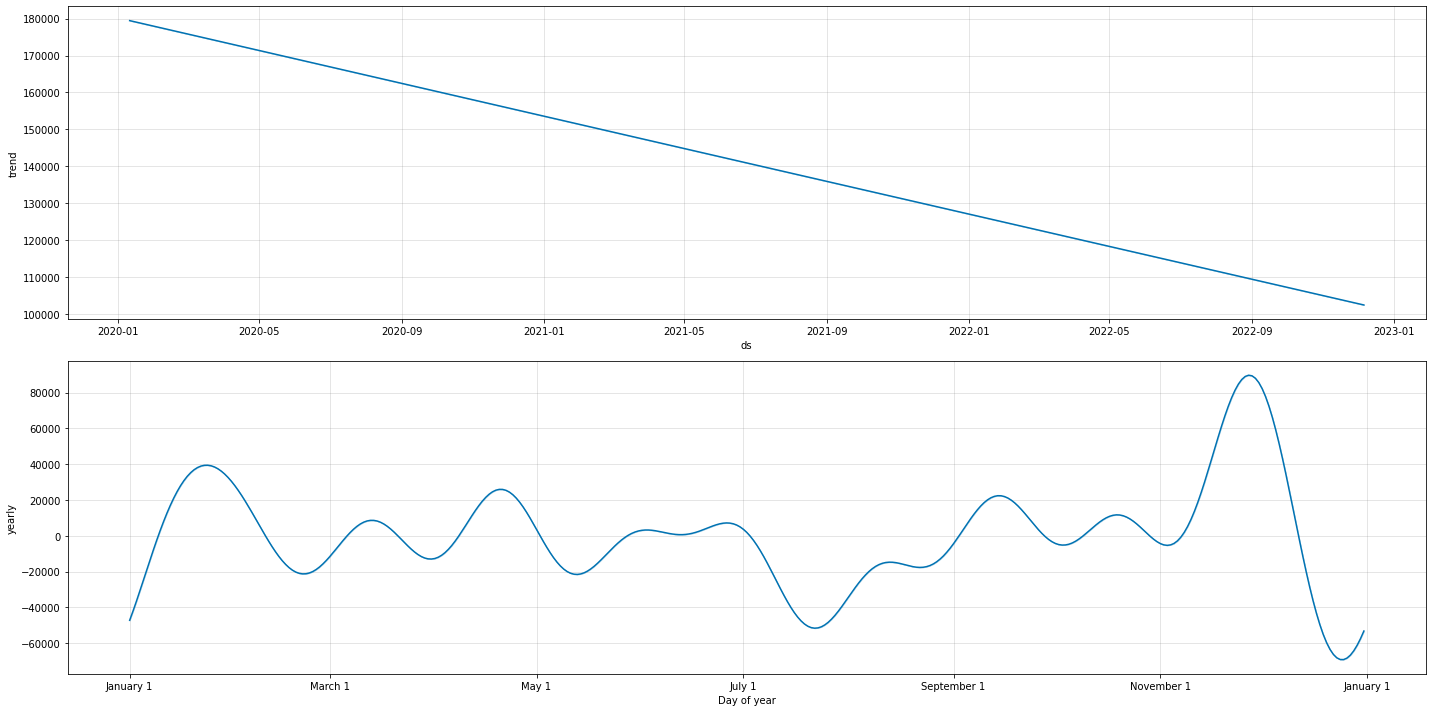

In [24]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

Adding the detected trend and seasonality signals back to the data table:

In [25]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]

final_data = data_wdates.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

The final feature (X) and target (y) data:

In [26]:
X = final_data.drop(columns=['revenue', 'start_of_week'])
y = final_data['revenue']

# The Model

## Carryover (adstock)
For modelling carryover, following Jin et al. 2017, we use an adstock function of form:

$$ 
x^*_{t,m} = \frac{\sum_l w_m(l)x_{t-l,m}}{\sum_l w_m(l)}
$$

Here, $w_m$ is a nonnegative weight function, which can be described with a geometric decay function, i.e., 

$$
w^g_m = \alpha_m^l,~l = 0, 1, ..., L-1,~0<\alpha_m<1
$$

where, $w_m$ describes the weight of the effect on each time step $l$, that lasts for $L$ time steps (which we here prescribe to be 13 time steps, i.e., weeks, which is a good approximation for infinity according to Jin et al. 2017), and $\alpha_m$ is the decay rate for the channel $m$.

In order to account for potential delays in the media effects, following Jin et al. 2017 again, we can add $\theta_m$, the delay of the peak effect for the media channel $m$ into the equation above as follows:

$$
w^d_m = \alpha_m^{(l-\theta_m)^2},~l = 0, 1, ..., L-1,~0<\alpha_m<1,~0 \leq \theta_m \leq L-1 
$$

In [27]:
def adstock_weights(alpha, theta, length=13, delayed=False):
    if delayed:
        w = [tt.power(alpha, (i-theta)^2) for i in range(length)]
    else:
        w = [tt.power(alpha, i) for i in range(length)]
    
    w = tt.as_tensor_variable(w)
    
    return w

    #x_lags = tt.stack(
    #    [tt.concatenate([tt.zeros(i),x[:x.shape[0]-i]]) for i in range(length)]
    #)
    
    #return tt.dot(w, x_lags)

In [28]:
def carryover (x, alpha, theta=0, length=13, delayed=False):
  
    w = adstock_weights(alpha, theta, length, delayed)
    
    x_lags = tt.stack(
        [tt.concatenate([tt.zeros(i),x[:x.shape[0]-i]]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

Next, we build a model that consists of delayed media channels and control variables:

$$
\hat{y} = \epsilon + \tau +  \sum_c \gamma_c z_{t,c} + \sum_m  \beta_m x^*_{t,m}  
$$

where, $\epsilon$ and $\tau$ represent noise and baseline revenue, $z_{t,c}$ and $\gamma$ represent the control variable $c$ and their effects, and $x^*_{t,m}$ and $\beta_m$ represent the (adstocked) media spending $m$ and their effects, respectively. 

Note that here for simplicity, we assume no shape effects (i.e., no saturation). We further assume that marketing contributions can only be positive, which can be achieved by drawing the contribution coefficient from a half-normal distribution.

In [29]:
control_variables = ["trend", "season"]
media_channels = [f'spend_channel_{i}' for i in range(1,8)]
transform_variables = control_variables+media_channels

y_transformed=y/10000 #rescale target variable

X_transformed = X.copy() #Min-max scale the features

numerical_encoder_dict = {}
for feature in transform_variables:
    scaler = MinMaxScaler()
    original = final_data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    X_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

with pm3.Model() as mmm1:

    #baseline (tau) and noise
    base = pm3.Normal("base", np.mean(y_transformed.values), sigma = 2) #tau
    #base = pm3.Exponential('base', lam=0.01)
    noise = pm3.Exponential('noise', lam=0.1) #epsilon

    #media effects
    channel_contributions = []
    for channel in media_channels:
        print(f"Media channels: Adding {channel}")
        x = X_transformed[channel].values
        #Force the channel coefficients to be normal:
        beta = pm3.HalfNormal(f'beta_{channel}', sigma = 2)
        #adstock decay
        alpha = pm3.Beta(f'alpha_{channel}', alpha=2, beta=2)
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            beta * carryover(
                    x,
                    alpha
                    ),
            )
        channel_contributions.append(channel_contribution)
    
    #control effects
    control_contributions = []
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        z = X_transformed[control_var].values
        #control variables
        gamma = pm3.Normal(f"gamma_{control_var}", sigma = 3)
        control_effect = gamma * z
        control_contributions.append(control_effect)

    #add everything
    revenue = pm3.Normal(
        'revenue',
        mu= base + sum(control_contributions) + sum(channel_contributions),
        sigma=noise,
        observed=y_transformed
    )

Media channels: Adding spend_channel_1
Media channels: Adding spend_channel_2
Media channels: Adding spend_channel_3
Media channels: Adding spend_channel_4
Media channels: Adding spend_channel_5
Media channels: Adding spend_channel_6
Media channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season


## Do the prior distributions make sense?

We can check whether the model estimates based on priors more or less make sense, as can be judged from a rough alignment of the corresponding estimates with the observations.

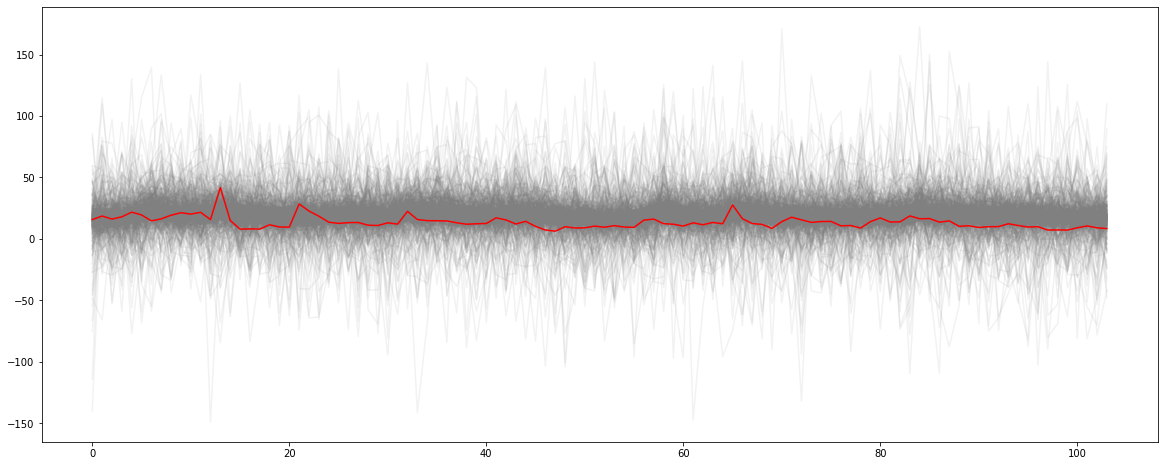

In [30]:
with mmm1:
    prior_pred = pm3.sample_prior_predictive()
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["revenue"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(y_transformed.values, color = "red")

Check the prior distributions:

alpha priors: 7
beta priors: 7
gamma priors: 4


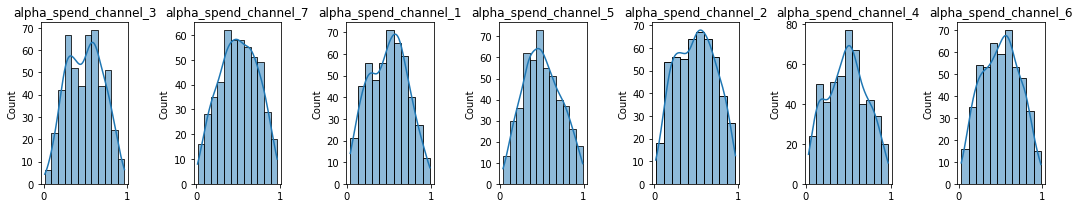

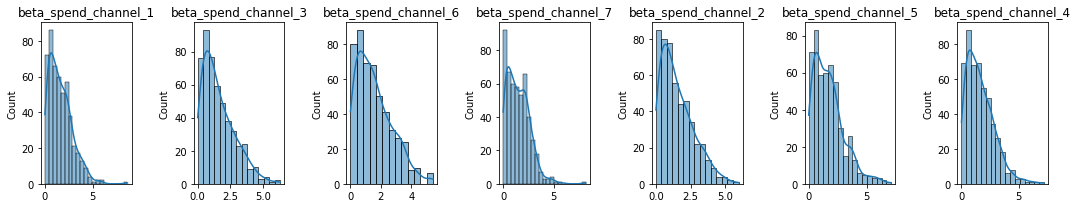

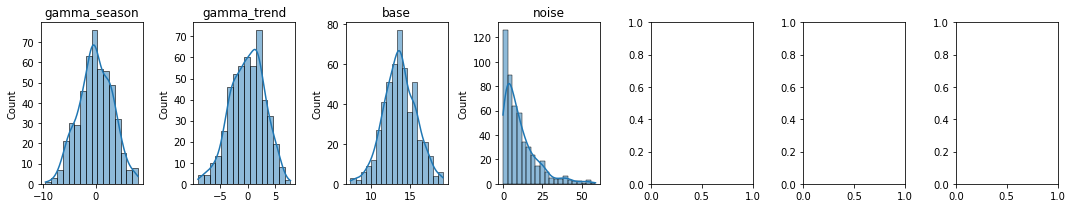

In [31]:
#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm3.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 7
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm3.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    

adstock_priors = [p for p in prior_names if p.startswith("alpha")]
plot_priors(adstock_priors, prior_pred)
print(f"alpha priors: {len(adstock_priors)}")

media_coef_priors = [p for p in prior_names if p.startswith("beta")]
plot_priors(media_coef_priors, prior_pred)
print(f"beta priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.startswith("gamma_")] + ["base", "noise"]
plot_priors(control_coef_priors, prior_pred)
print(f"gamma priors: {len(control_coef_priors)}")


## Fit the model

In [32]:
with mmm1:
  trace = pm3.sample(return_inferencedata=True, tune=3000, target_accept=0.95)
  trace_summary = az.summary(trace)

/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [33]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
base,6.826,1.122,4.830,9.012,0.030,0.021,1433.0,1642.0,1.0
gamma_trend,2.108,1.962,-1.525,5.861,0.053,0.037,1385.0,1243.0,1.0
gamma_season,4.776,1.720,1.707,7.990,0.036,0.026,2299.0,1813.0,1.0
noise,3.920,0.310,3.389,4.524,0.008,0.005,1788.0,1354.0,1.0
beta_spend_channel_1,0.921,0.782,0.002,2.399,0.016,0.011,1672.0,852.0,1.0
...,...,...,...,...,...,...,...,...,...
contribution_spend_channel_7[99],0.468,0.321,0.006,1.046,0.007,0.005,1797.0,1353.0,1.0
contribution_spend_channel_7[100],0.475,0.315,0.005,1.024,0.007,0.005,1769.0,1298.0,1.0
contribution_spend_channel_7[101],0.631,0.409,0.006,1.343,0.009,0.006,1733.0,1232.0,1.0
contribution_spend_channel_7[102],0.648,0.421,0.007,1.391,0.009,0.007,1742.0,1215.0,1.0


# Analysis

## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2532fe2250>,
      dtype=object)

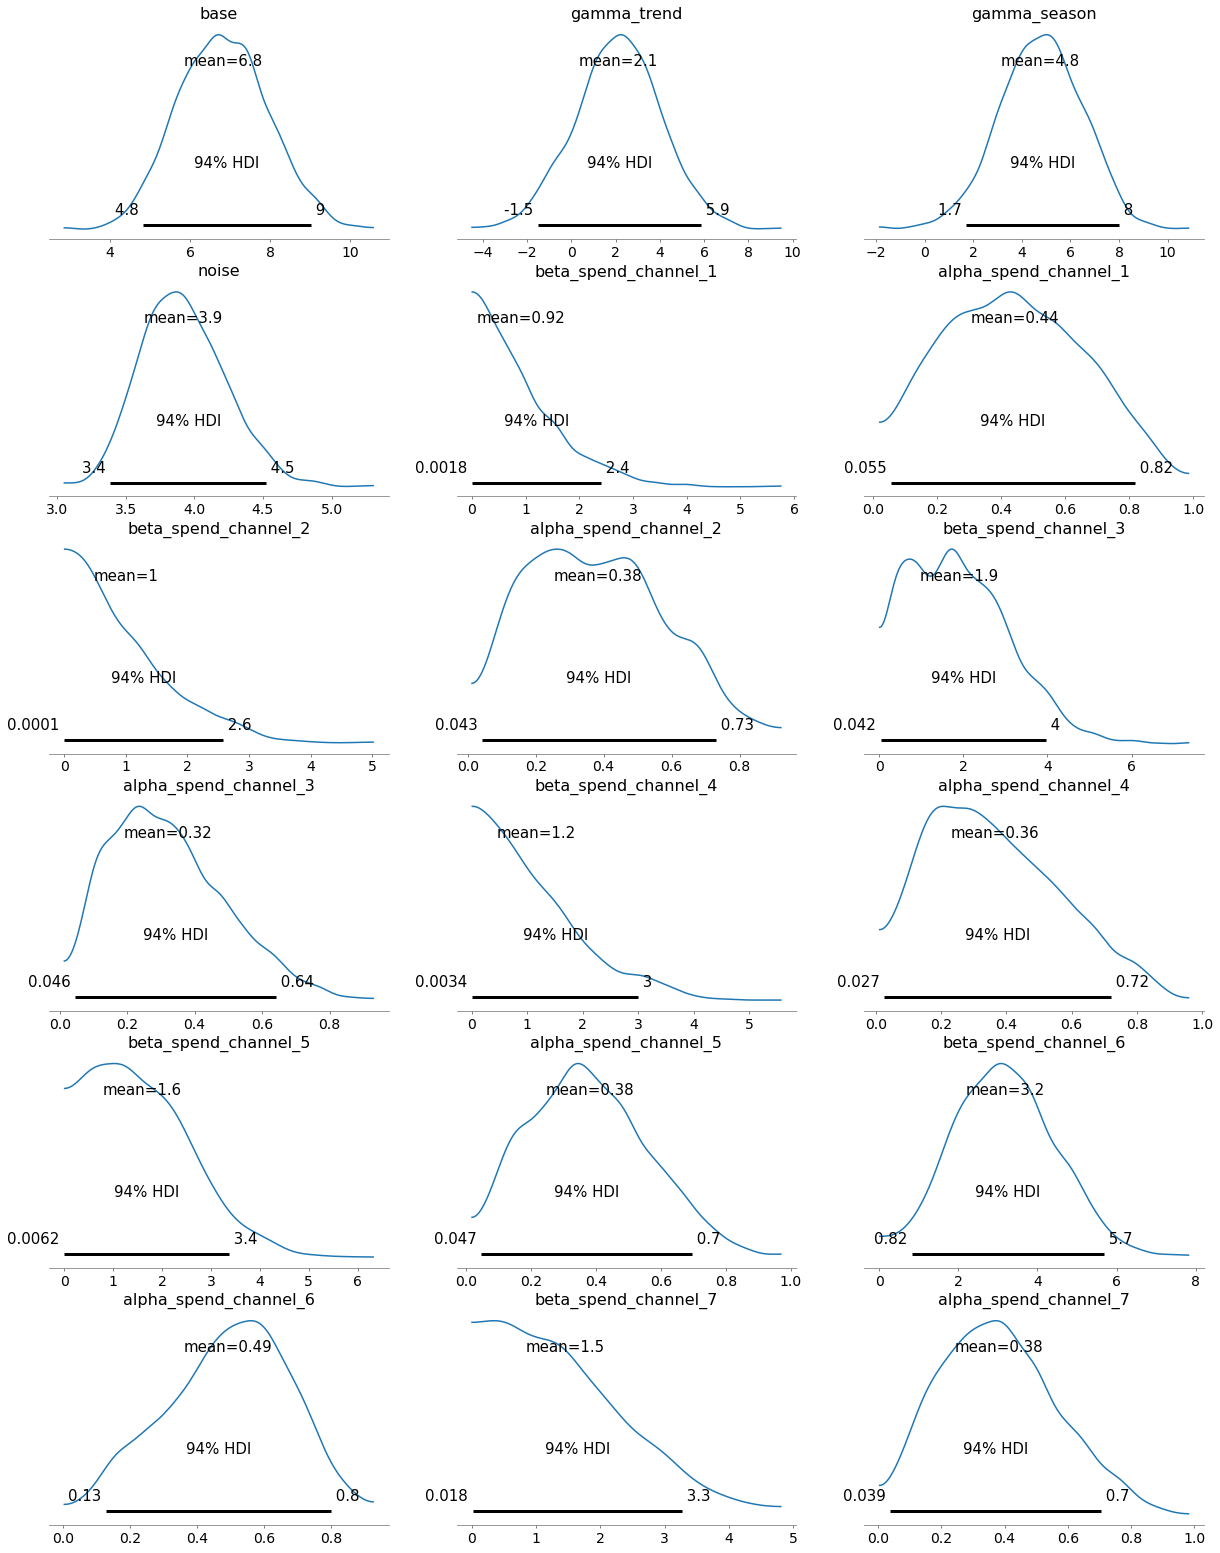

In [34]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

We can now check the model skill by plotting the predictions and observations together, and calculating, e.g., MAE.

In [35]:
with mmm1:
    posterior = pm3.sample_posterior_predictive(trace)

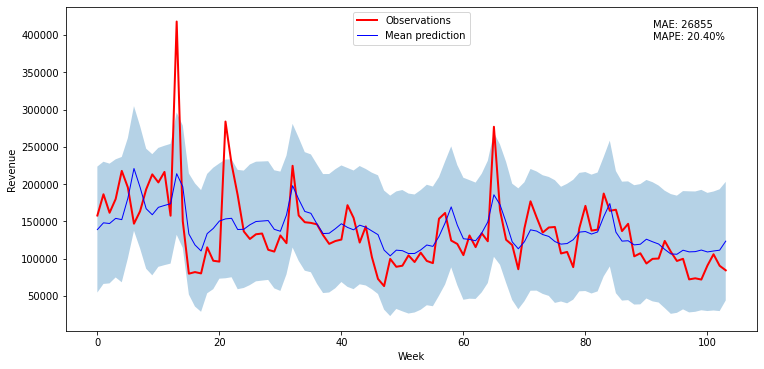

In [36]:
y_pred = posterior['revenue'].mean(0)*10000
y_stds = posterior['revenue'].std(0)*10000

MAE = mean_absolute_error(y.values, y_pred)
MAPE = mean_absolute_percentage_error(y.values, y_pred)*100
SkillStr = 'MAE: %5d\nMAPE: %5.2f%%'%(MAE,MAPE)
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.15,
                        bottom=0.15,
                        right=0.95,
                        top=0.9)
ax.plot(y.values, linewidth=2, c='r', label='Observations')
ax.plot(y_pred, linewidth=1, c='b', label='Mean prediction')
ax.fill_between(np.arange(len(y)), y_pred - 2*y_stds, y_pred + 2*y_stds, alpha=0.33)
ax.text(0.85,0.9,SkillStr, transform=ax.transAxes)
ax.legend(loc='upper center')
ax.set_xlabel('Week')
ax.set_ylabel('Revenue')
plt.show()

Except for two weeks, the observations lay within 2 standard deviations plus/minus the predictions. That instance is likely due to a special event, like a promotion or a holiday, which is not accounted for by the model. The mean absolute error corresponds to about 20% of the revenue.

## Channel Contributions and ROI



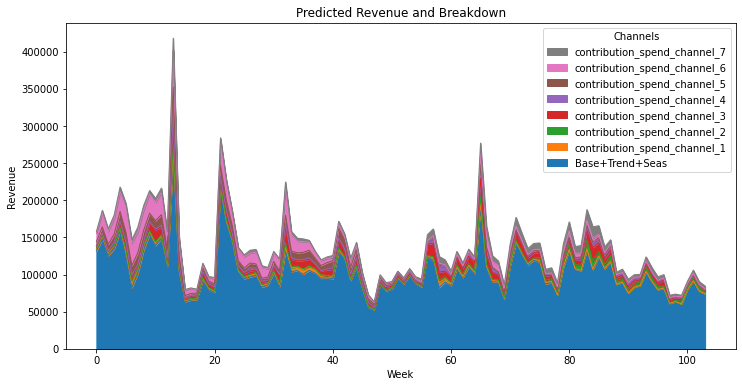

In [38]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'{channel}']
            .values
            .reshape(2000, 104)
            .mean(0)
           )

channels = [f'contribution_spend_channel_{i}' for i in range(1,8)]

unadj_contributions = pd.DataFrame(
    {'Base+Trend+Seas': trace.posterior['base'].values.mean()
                 +trace.posterior['gamma_trend'].values.mean()
                 +trace.posterior['gamma_season'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(12, 6),
          linewidth=1,
          title='Predicted Revenue and Breakdown',
          ylabel='Revenue',
          xlabel='Week'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="upper right",
    #bbox_to_anchor=(1.01, 0.5)
)
plt.show()

According to this plot, the model suggests that a large portion of the revenue is not explained by marketing actions.

For each channel $m$, percentage $ROI_m$ can be calculated according to:

$ROI_m = \frac{\sum_t C_{t,m} - \sum_t S_{t,m}}{\sum_t S_{t,m}} * 100$

where $C_{t,m}$ and $S_{t,m}$ are the revenue contribution and spends to the media channel $m$ at a given time step ($t$).

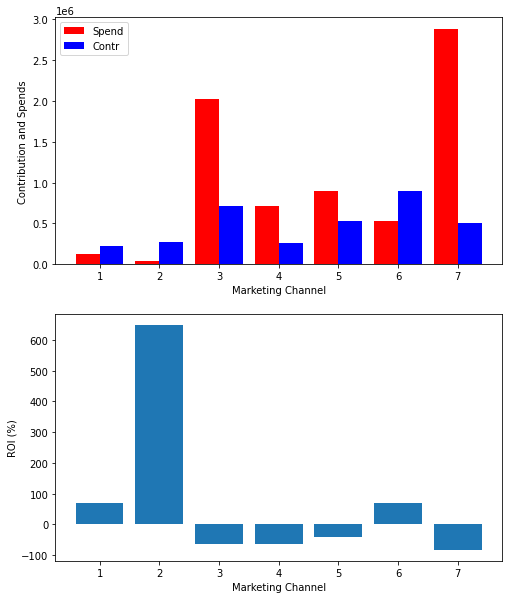

In [39]:
#Calculate ROI for each channel
total_contr = adj_contributions.sum(axis=0)
total_spend = X.sum(axis=0)

Cchannels = [f'contribution_spend_channel_{i}' for i in range(1,8)]
            
Schannels = [f'spend_channel_{i}' for i in range(1,8)]

ROI_l= [None] * 7
spend_l = [None] * 7
contr_l = [None] * 7
for i in range(7):
    spend_l[i] = total_spend[Schannels[i]]
    contr_l[i] = total_contr[Cchannels[i]]
    ROI_l[i] = (contr_l[i] - spend_l[i])/spend_l[i] *100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.bar(np.arange(1,8) - 0.2, spend_l, color = 'r', width = 0.4, label='Spend')
ax1.bar(np.arange(1,8) + 0.2, contr_l, color = 'b', width = 0.4, label='Contr')
ax1.set_xlabel('Marketing Channel')
ax1.set_ylabel('Contribution and Spends')
ax1.legend(loc='upper left')

ax2.bar(range(1,8),ROI_l)
ax2.set_xlabel('Marketing Channel')
ax2.set_ylabel('ROI (%)')

plt.show()


Our model suggests that only channels 1, 2 and 6 generate positive net gains. Among these channels, 2 seems most effective in terms of ROI, however, in terms of absolute revenue contribution, channel 6 is the most important source. Among the channels that results in net costs channel 7 is the one that requires most immediate attenion, both in terms of ROI and absolute net cost. Continued investment in channels 3 and 4 seem also questionable.